In [1]:
from transformers import pipeline

In [3]:
# Mask Generation with SAM. The Segment Anything Model (SAM) model was released by Meta AI.
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [5]:
from PIL import Image

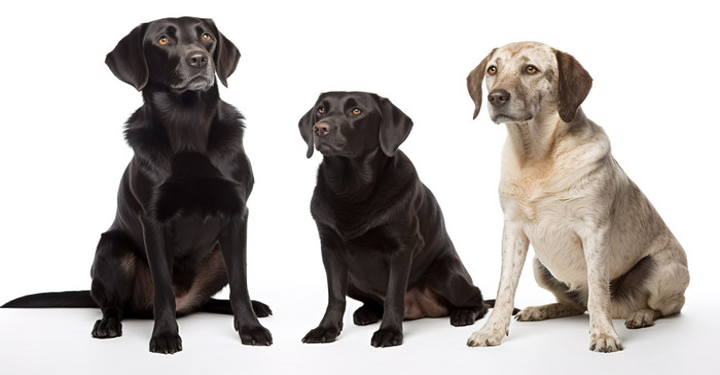

In [ ]:
raw_image = Image.open('./data/dogs_image.jpg')
raw_image.resize((720, 375))

In [9]:
output = sam_pipe(raw_image, points_per_batch=32)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

def show_masks_on_image(image, masks, alpha=0.5):
    """
    Visualize segmentation masks on the image with different colors.
    
    Args:
        image: PIL Image or numpy array (H x W x 3)
        masks: list or array of masks (each mask is H x W, bool or 0/1)
        alpha: transparency for mask overlay
    """
    if isinstance(image, Image.Image):
        image = np.array(image)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    for mask in masks:
        mask = np.array(mask).astype(bool)
        
        # Random RGB color
        color = (random.random(), random.random(), random.random())
        
        # Create colored mask
        colored_mask = np.zeros((*mask.shape, 4))  # RGBA
        colored_mask[..., 0] = color[0]
        colored_mask[..., 1] = color[1]
        colored_mask[..., 2] = color[2]
        colored_mask[..., 3] = mask * alpha  # Alpha channel

        plt.imshow(colored_mask)

    plt.axis('off')
    plt.show()


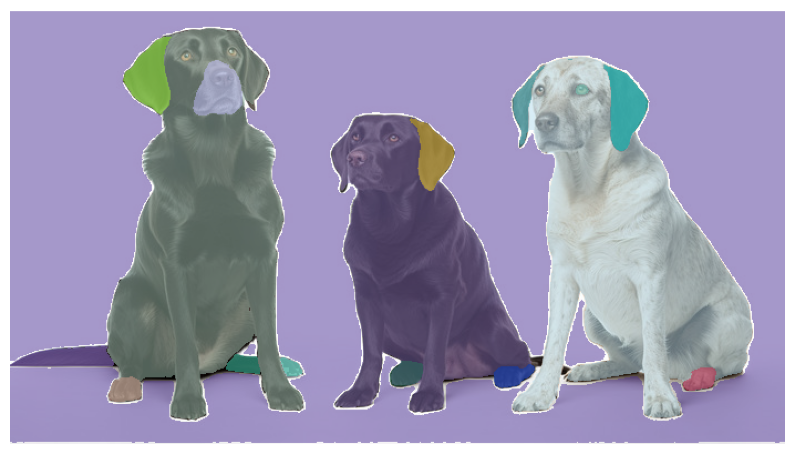

In [17]:
show_masks_on_image(raw_image, output["masks"])

Faster Inference: Infer an Image and a Single Point

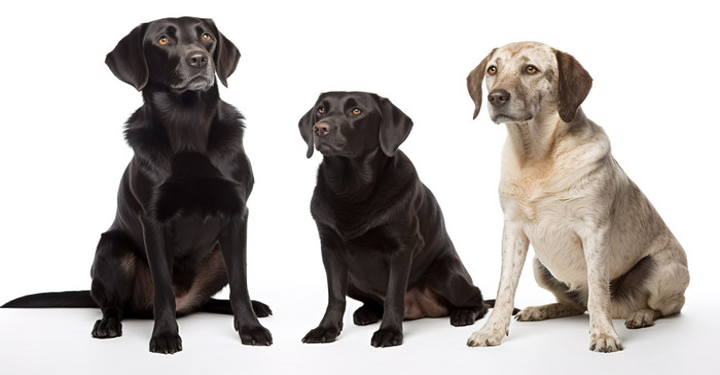

In [19]:
from transformers import SamModel, SamProcessor
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")
raw_image.resize((720, 375))

In [23]:
input_points = [[[541, 155]]]

In [25]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

In [27]:
import torch
with torch.no_grad():
    outputs = model(**inputs)

with torch.no_grad():
    outputs = model(**inputs)

In [29]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)
len(predicted_masks)

1

In [31]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 392, 700])

In [33]:
outputs.iou_scores

tensor([[[0.8810, 0.9562, 0.7671]]])

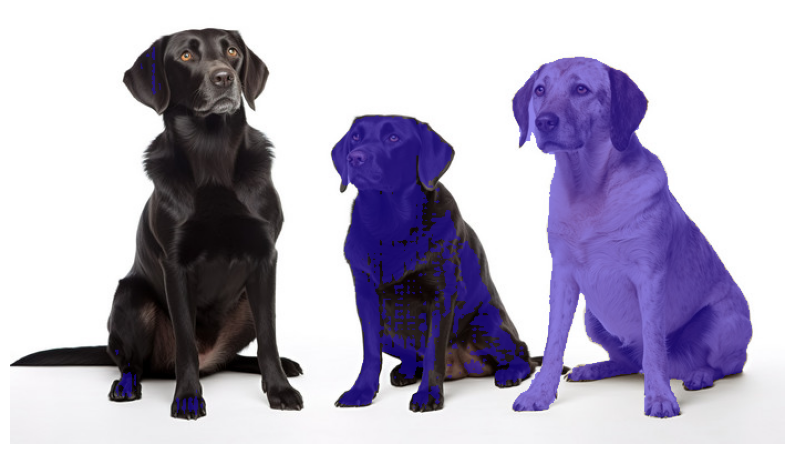

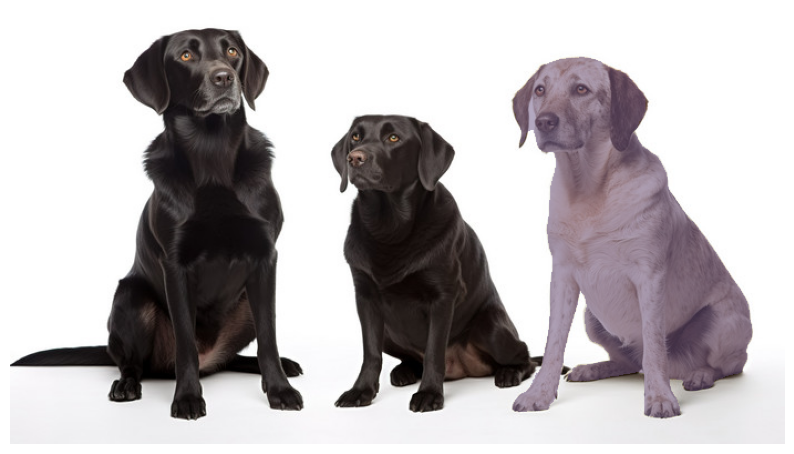

In [67]:
for i in range(2):
    show_masks_on_image(raw_image, predicted_mask[:, i])

Depth Estimation with DPT

In [61]:
depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

config.json: 0.00B [00:00, ?B/s]

C:\Users\mkhani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mkhani\.cache\huggingface\hub\models--Intel--dpt-hybrid-midas. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled 

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

Device set to use cpu
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


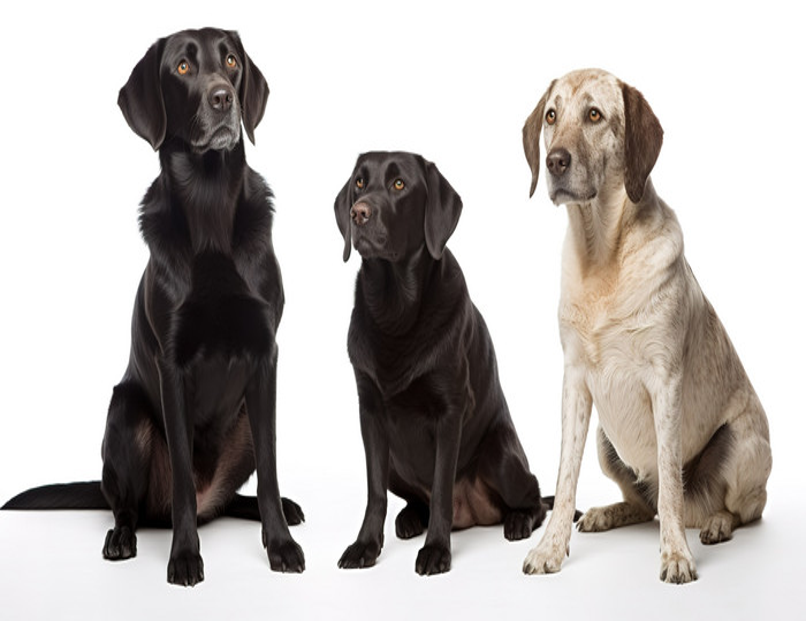

In [69]:
raw_image = Image.open('gradio_tamagochi_vienna.png')
raw_image.resize((806, 621))

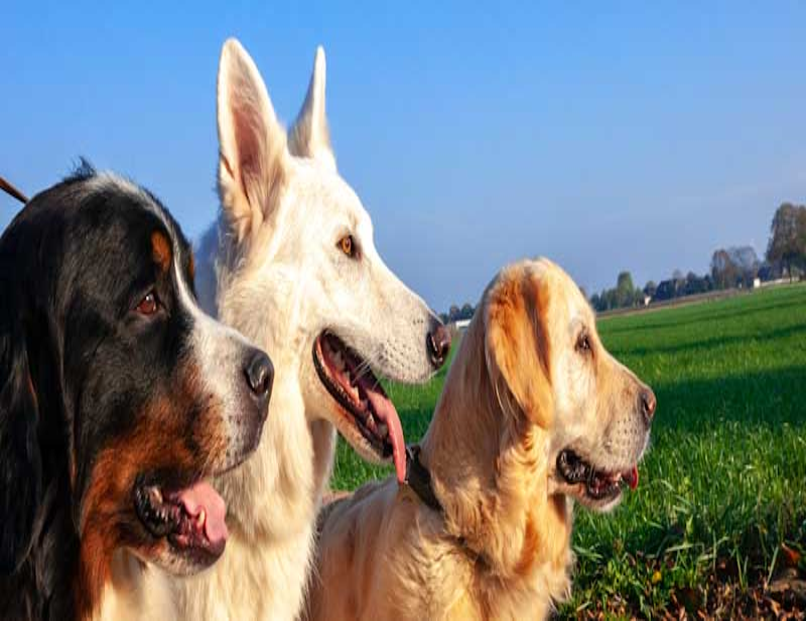

In [ ]:
raw_image = Image.open('./data/dogs_image_2.jpg')
raw_image.resize((806, 621))

In [145]:
output = depth_estimator(raw_image)

In [146]:
output["predicted_depth"].shape

torch.Size([354, 800])

In [147]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([354, 1, 800])

In [ ]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [ ]:
from PIL import Image
import torch

# Load and resize image
raw_image = Image.open('./data/dogs_image_2.jpg').resize((806, 621))

# Run depth estimation
output = depth_estimator(raw_image)

# If predicted_depth is [H, W] -> make it [1, 1, H, W]
depth = output["predicted_depth"].unsqueeze(0).unsqueeze(0)

# Interpolate to match original image size
depth_resized = torch.nn.functional.interpolate(
    depth,
    size=(raw_image.size[1], raw_image.size[0]),  # (height, width)
    mode="bicubic",
    align_corners=False
)

print(depth_resized.shape)  # Should be [1, 1, height, width]

torch.Size([1, 1, 621, 806])


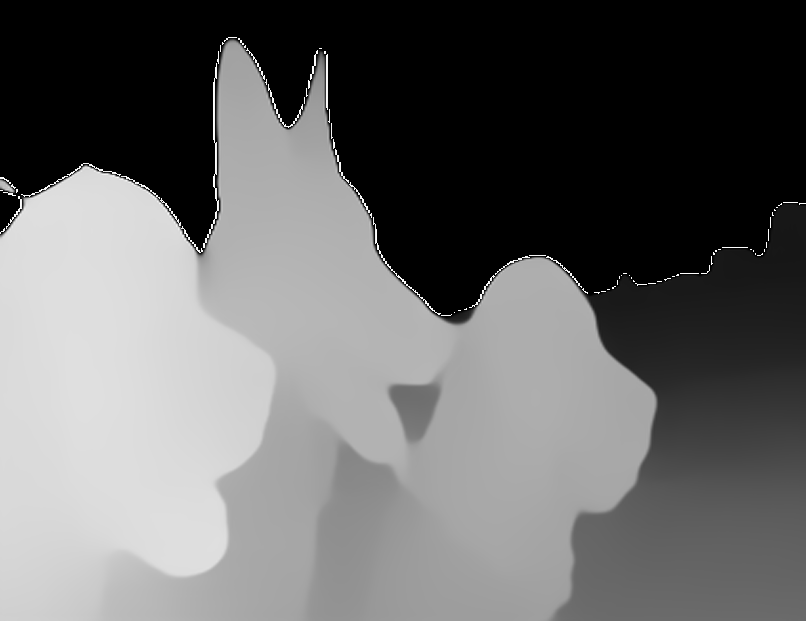

In [163]:
import numpy as np 
output = depth_resized.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth